In [12]:
from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [13]:
DATASET_PATH = Path() / '..' / '..' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [14]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [15]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)


(course_ocr_t1.data.MidvPackage, 300, course_ocr_t1.data.DataItem)

In [16]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(PosixPath('../../midv500_compressed/01_alb_id/ground_truth/PS/PS01_11.json'),
 PosixPath('../../midv500_compressed/01_alb_id/images/PS/PS01_11.tif'))

In [17]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[220, 299],
       [598, 315],
       [626, 571],
       [202, 541]])

[[0.48888889 0.37375   ]
 [1.32888889 0.39375   ]
 [1.39111111 0.71375   ]
 [0.44888889 0.67625   ]]


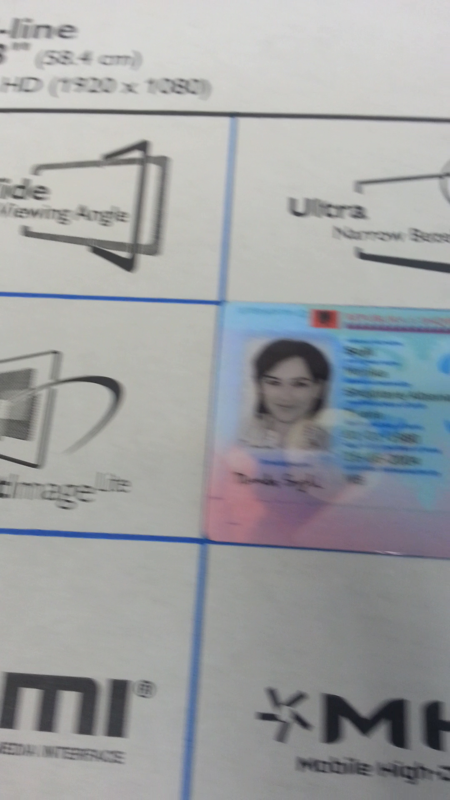

In [18]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

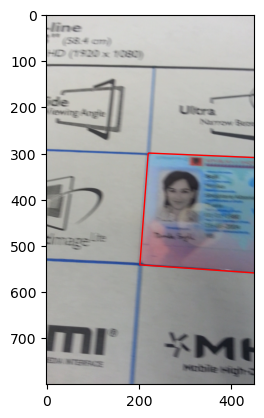

In [19]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [20]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, False)

True


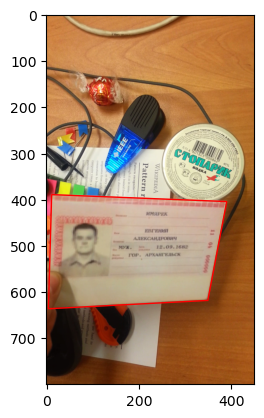

In [21]:
print(data_packs[38][238].is_test_split())
data_packs[38][238].show()

In [22]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.72it/s]

В 9992 из 15000 случаев разметка кропа(т.е. документ) целиком в кадре


In [23]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 295.81it/s]

В 4250 из 15000 случаев кадр принадлежит к test-split


## Classic CV baseline

### Для работы baseline нужен установленныей OpenCV 

In [24]:
import cv2

In [25]:
class SimpleBaselineCrop:
    """
    Baseline на основе поиска и сопоставления ключевых точек на шаблоне(ref) и запросе(query)
    Алгоритм:
        0. Найти ключевые точки(КТ) на ref
        1. Найти ключевые точки(КТ) на query
        2. Сопоставить КТ query и ref друг-другу
        3. На основе сопоставления найти гомографию из ref в query
        4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
    """
    def __init__(self, ref_image):
        self.ref_image = ref_image
        
        # 0. Найти ключевые точки(КТ) на ref
        self.ref_kpts, self.ref_fts = self.compute_kps(
            self.ref_image
        )

    def compute_kps(self, img, response_quantile=0.25):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sift = cv2.SIFT_create()
        kp = sift.detect(gray, None)
        # фильтруем 25% неуверенных точек
        q_val = np.quantile(list(k.response for k in kp), response_quantile)
        kp = [k for k in kp if k.response > q_val]
        
        kp, features = sift.compute(gray, kp)
        return kp, features 
    
    def find_qr_homography(self, kp_q, ft_q, kp_r, ft_r, ratio=0.75):
        # 2. Сопоставить КТ query и ref друг-другу
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(ft_q, ft_r, k=2)
        good = []

        # Дополнителный опциональный шаг - фильтрация Lowe, Lowe ratio-test:
        # Пусть есть лучший матч1 (query-kp, ref-kp)
        # Если есть другой возможный матч2 (query-kp, ref-kp2), и их качество
        # (т.е. расстояние в пространстве features) маленькое,
        # то нельзя быть уверенном, что матч1 - надежный, и проще его выбросить
        for m,n in matches:
            if m.distance <  ratio * n.distance:
                good.append([m])
                
        ptsA = np.zeros((len(good), 2), dtype="float")
        ptsB = np.zeros((len(good), 2), dtype="float")

        for (i, mlist) in enumerate(good):
            m = mlist[0]
            ptsA[i] = kp_q[m.queryIdx].pt
            ptsB[i] = kp_r[m.trainIdx].pt
        # 3. На основе сопоставления найти гомографию из ref в query
        (H, mask) = cv2.findHomography(ptsB, ptsA, method=cv2.RANSAC)
        return H
              
    def compute_crop(self, ref_img, hmg):
        # 4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
        h, w, _ = ref_img.shape
        h = float(h)
        w = float(w)
        points = [
            [0, 0],
            [w, 0],
            [w, h],
            [0, h],
        ]
        points_crop = []
        for p in points:
            # применяем гомографию к точке, представленной в гомогенных координатах
            vec = hmg @ np.array([p[0], p[1], 1])
            points_crop.append([vec[0]/vec[-1], vec[1]/vec[-1]])
        return np.array(points_crop)
        
    def __call__(self, query_image):
        # 1. Найти ключевые точки(КТ) на query
        kpts, fts = self.compute_kps(query_image)
        
        homography = self.find_qr_homography(
            kpts, fts, self.ref_kpts, self.ref_fts
        )
        abs_crop = self.compute_crop(self.ref_image, homography)
        h, w, _ = query_image.shape
        rel_crop = abs_crop / np.array([[w, h]])
        return rel_crop

In [26]:
bcm = SimpleBaselineCrop(np.array(dp.template_item.image))

In [27]:
pred_quad = bcm(np.array(dp[0].image))

In [28]:
pred_quad, dp[0].quadrangle

(array([[0.05690939, 0.47378273],
        [0.73707284, 0.33397009],
        [0.92773878, 0.56708375],
        [0.22825794, 0.72939492]]),
 array([[0.05555556, 0.47375   ],
        [0.73555556, 0.335     ],
        [0.92666667, 0.5675    ],
        [0.22666667, 0.72875   ]]))

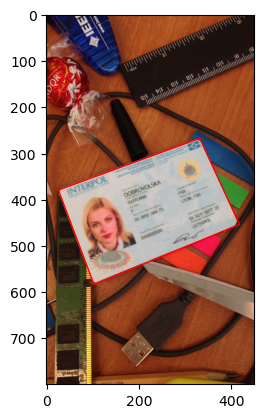

In [29]:
dp[0].show(pred_quad)

In [30]:
results_dict = dict()

for dp in tqdm(data_packs):
    bcm = SimpleBaselineCrop(np.array(dp.template_item.image))
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                results_dict[dp[i].unique_key] = bcm(np.array(dp[i].image))
                print(bcm(np.array(dp[i].image)))
                break
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)


  2%|▉                                           | 1/50 [00:00<00:14,  3.40it/s]

[[0.05580827 0.33688185]
 [0.84191802 0.31796367]
 [0.8688937  0.59186544]
 [0.08210755 0.61884111]]


  4%|█▊                                          | 2/50 [00:00<00:14,  3.27it/s]

[[0.04374843 0.54433575]
 [0.77750566 0.41626385]
 [0.92102839 0.67223517]
 [0.19281755 0.80754763]]


  6%|██▋                                         | 3/50 [00:00<00:14,  3.30it/s]

[[0.08406458 0.43591022]
 [0.70624595 0.2833254 ]
 [0.87231671 0.50827216]
 [0.24231308 0.6504275 ]]


  8%|███▌                                        | 4/50 [00:01<00:13,  3.30it/s]

[[0.13483808 0.34379626]
 [0.79098154 0.20344134]
 [0.98032108 0.42087172]
 [0.29826079 0.57618061]]


 10%|████▍                                       | 5/50 [00:01<00:13,  3.25it/s]

[[0.14412431 0.44111859]
 [0.98470915 0.54207909]
 [0.85869996 0.87388412]
 [0.03491502 0.76310096]]


 12%|█████▎                                      | 6/50 [00:01<00:13,  3.23it/s]

[[0.11136101 0.36231538]
 [0.84401733 0.3125742 ]
 [0.90148195 0.60582485]
 [0.1646121  0.64868754]]


 14%|██████▏                                     | 7/50 [00:02<00:13,  3.25it/s]

[[0.18014514 0.32640989]
 [0.93294775 0.39877196]
 [0.82914169 0.68751841]
 [0.07671852 0.58698314]]


 16%|███████                                     | 8/50 [00:02<00:12,  3.29it/s]

[[0.17277112 0.23915284]
 [0.93051978 0.31126385]
 [0.83606001 0.58687623]
 [0.06503863 0.49769027]]


 18%|███████▉                                    | 9/50 [00:02<00:12,  3.32it/s]

[[0.26225032 0.35025962]
 [0.85718831 0.42388377]
 [0.74964591 0.64940109]
 [0.15072968 0.55640883]]


 20%|████████▌                                  | 10/50 [00:03<00:12,  3.29it/s]

[[0.22719772 0.38309765]
 [0.8284291  0.48445385]
 [0.70583435 0.7048361 ]
 [0.10604987 0.59161139]]


 22%|█████████▍                                 | 11/50 [00:03<00:12,  3.22it/s]

[[0.03597006 0.36439018]
 [0.84020949 0.35923128]
 [0.85521846 0.68703302]
 [0.01267409 0.68470058]]


 24%|██████████▎                                | 12/50 [00:03<00:11,  3.25it/s]

[[0.16054344 0.45945676]
 [0.90666011 0.52597632]
 [0.83796185 0.79641155]
 [0.07933666 0.71934885]]


 26%|███████████▏                               | 13/50 [00:03<00:11,  3.27it/s]

[[0.05856339 0.45173037]
 [0.76472291 0.35121708]
 [0.90741759 0.59676218]
 [0.17350432 0.70937857]]


 28%|████████████                               | 14/50 [00:04<00:10,  3.29it/s]

[[0.02731563 0.3676653 ]
 [0.7614539  0.32133924]
 [0.81181772 0.58416307]
 [0.06751475 0.62357162]]


 30%|████████████▉                              | 15/50 [00:04<00:10,  3.21it/s]

[[0.13629186 0.39582148]
 [0.73325627 0.3017165 ]
 [0.86827611 0.53176273]
 [0.24995841 0.63328622]]


 32%|█████████████▊                             | 16/50 [00:04<00:10,  3.17it/s]

[[0.12746707 0.33851183]
 [0.82795808 0.27022594]
 [0.92283196 0.54606771]
 [0.20864537 0.61692741]]


 34%|██████████████▌                            | 17/50 [00:05<00:10,  3.13it/s]

[[0.1152925  0.2966209 ]
 [0.96801455 0.40275176]
 [0.82852519 0.71628722]
 [0.01734746 0.6141196 ]]


 36%|███████████████▍                           | 18/50 [00:05<00:10,  3.16it/s]

[[0.02806674 0.34930274]
 [0.90758368 0.3250601 ]
 [0.92352674 0.68949262]
 [0.05502975 0.6887655 ]]


 38%|████████████████▎                          | 19/50 [00:05<00:09,  3.20it/s]

[[0.17113112 0.25546715]
 [0.89641123 0.34637044]
 [0.78642049 0.60583734]
 [0.03974283 0.50159522]]


 40%|█████████████████▏                         | 20/50 [00:06<00:09,  3.25it/s]

[[0.07909795 0.27222823]
 [0.83096789 0.2871931 ]
 [0.80403935 0.54847031]
 [0.08346201 0.53121966]]


 42%|██████████████████                         | 21/50 [00:06<00:08,  3.28it/s]

[[0.12192288 0.30564273]
 [0.84794769 0.3109216 ]
 [0.85056594 0.5663632 ]
 [0.10444013 0.56171658]]


 44%|██████████████████▉                        | 22/50 [00:06<00:08,  3.29it/s]

[[0.35316549 0.31161105]
 [1.02963533 0.54636935]
 [0.74776621 0.79347966]
 [0.09812332 0.54168593]]


 46%|███████████████████▊                       | 23/50 [00:07<00:08,  3.30it/s]

[[0.22974851 0.30791063]
 [0.80989923 0.40256806]
 [0.69708725 0.61164093]
 [0.1009021  0.50408382]]


 48%|████████████████████▋                      | 24/50 [00:07<00:07,  3.26it/s]

[[0.09396627 0.66486531]
 [0.75990146 0.60670025]
 [0.8593598  0.85049231]
 [0.13759944 0.92182788]]


 50%|█████████████████████▌                     | 25/50 [00:07<00:07,  3.24it/s]

[[0.12705559 0.31914667]
 [0.85335841 0.2798558 ]
 [0.90050653 0.5655353 ]
 [0.18177869 0.60641955]]


 52%|██████████████████████▎                    | 26/50 [00:08<00:07,  3.23it/s]

[[0.00830977 0.30893385]
 [0.85039937 0.2377071 ]
 [0.94930278 0.53483221]
 [0.07185698 0.60696867]]


 54%|███████████████████████▏                   | 27/50 [00:08<00:07,  3.23it/s]

[[0.02189951 0.36549674]
 [0.92724219 0.33376397]
 [0.96028609 0.67782273]
 [0.08043872 0.71618272]]


 56%|████████████████████████                   | 28/50 [00:08<00:06,  3.19it/s]

[[0.12386    0.36282613]
 [0.87392986 0.40706556]
 [0.83082122 0.70974119]
 [0.0516256  0.66269231]]


 58%|████████████████████████▉                  | 29/50 [00:08<00:06,  3.25it/s]

[[0.16572686 0.38635374]
 [0.77087548 0.34018054]
 [0.80677739 0.57287609]
 [0.18207344 0.6010849 ]]


 60%|█████████████████████████▊                 | 30/50 [00:09<00:06,  3.28it/s]

[[0.17845216 0.43967839]
 [0.84493463 0.45173224]
 [0.84268231 0.69017668]
 [0.13729765 0.67203757]]


 62%|██████████████████████████▋                | 31/50 [00:09<00:05,  3.27it/s]

[[0.04487153 0.4867532 ]
 [0.79718631 0.3707251 ]
 [0.95640616 0.6323309 ]
 [0.17093101 0.76338034]]


 64%|███████████████████████████▌               | 32/50 [00:09<00:05,  3.22it/s]

[[0.08609199 0.37813784]
 [0.99701692 0.42400539]
 [0.93070052 0.78646999]
 [0.04245979 0.72381212]]


 66%|████████████████████████████▍              | 33/50 [00:10<00:05,  3.26it/s]

[[0.12012162 0.49540522]
 [0.85631718 0.37658926]
 [1.00700798 0.63312364]
 [0.25421648 0.76240127]]


 68%|█████████████████████████████▏             | 34/50 [00:10<00:05,  3.20it/s]

[[0.2070374  0.26529047]
 [0.90565952 0.3549612 ]
 [0.79403637 0.63298418]
 [0.09110789 0.54111203]]


 70%|██████████████████████████████             | 35/50 [00:10<00:04,  3.26it/s]

[[0.16346551 0.41209564]
 [0.87510215 0.42820236]
 [0.8556222  0.69166258]
 [0.10279712 0.66096524]]


 72%|██████████████████████████████▉            | 36/50 [00:11<00:04,  3.26it/s]

[[0.12296385 0.20017082]
 [0.85179251 0.23542831]
 [0.80169391 0.49862574]
 [0.06215311 0.45120935]]


 74%|███████████████████████████████▊           | 37/50 [00:11<00:03,  3.28it/s]

[[0.12455527 0.43461021]
 [0.8137181  0.38499208]
 [0.88992827 0.62700123]
 [0.14549082 0.67544128]]


 76%|████████████████████████████████▋          | 38/50 [00:11<00:03,  3.29it/s]

[[ 0.0523428   0.18306118]
 [ 0.87463268  0.21289116]
 [ 0.84406592  0.5019156 ]
 [-0.01866612  0.46175134]]


 78%|█████████████████████████████████▌         | 39/50 [00:11<00:03,  3.27it/s]

[[0.09631981 0.40153021]
 [0.84922607 0.40207763]
 [0.86031588 0.70214506]
 [0.08397159 0.69959719]]


 80%|██████████████████████████████████▍        | 40/50 [00:12<00:03,  3.21it/s]

[[0.1076484  0.40278665]
 [0.87670633 0.34238618]
 [0.95615414 0.61132573]
 [0.17669467 0.67716133]]


 82%|███████████████████████████████████▎       | 41/50 [00:12<00:02,  3.24it/s]

[[0.1447546  0.27081731]
 [0.96085475 0.32764492]
 [0.88064893 0.65818449]
 [0.07249211 0.58309796]]


 84%|████████████████████████████████████       | 42/50 [00:12<00:02,  3.25it/s]

[[0.08581926 0.4242543 ]
 [0.8523082  0.35711652]
 [0.92236817 0.6285883 ]
 [0.16075382 0.69010399]]


 86%|████████████████████████████████████▉      | 43/50 [00:13<00:02,  3.25it/s]

[[0.18761151 0.368666  ]
 [0.93444156 0.37408747]
 [0.94796326 0.63558529]
 [0.15326065 0.62637465]]


 88%|█████████████████████████████████████▊     | 44/50 [00:13<00:01,  3.28it/s]

[[0.09728773 0.34866321]
 [0.76651704 0.27936919]
 [0.83846705 0.52071144]
 [0.13359391 0.58186641]]


 90%|██████████████████████████████████████▋    | 45/50 [00:13<00:01,  3.25it/s]

[[0.01548031 0.36392967]
 [0.74474941 0.22681425]
 [0.93112413 0.50979277]
 [0.1868029  0.65713191]]


 92%|███████████████████████████████████████▌   | 46/50 [00:14<00:01,  3.22it/s]

[[0.19417684 0.29439909]
 [0.93438001 0.39669113]
 [0.81197141 0.69311057]
 [0.05567058 0.58740838]]


 94%|████████████████████████████████████████▍  | 47/50 [00:14<00:00,  3.24it/s]

[[0.15815558 0.35373106]
 [0.87331896 0.44613582]
 [0.74565873 0.71633036]
 [0.02204043 0.59891329]]


 96%|█████████████████████████████████████████▎ | 48/50 [00:14<00:00,  3.22it/s]

[[0.21559235 0.35327183]
 [0.86929159 0.38009536]
 [0.84559979 0.61439242]
 [0.16052848 0.58108983]]


 98%|██████████████████████████████████████████▏| 49/50 [00:15<00:00,  3.19it/s]

[[0.10557698 0.43022379]
 [0.78219608 0.33535854]
 [0.8810127  0.58725211]
 [0.14795249 0.67161798]]


100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]

[[0.05690939 0.47378273]
 [0.73707284 0.33397009]
 [0.92773878 0.56708375]
 [0.22825794 0.72939492]]


### Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [31]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [32]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [33]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [22]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.9609


In [34]:
results_dict

{'01_alb_id|ground_truth|CA|CA01_26.json': array([[0.05580827, 0.33688185],
        [0.84191802, 0.31796367],
        [0.8688937 , 0.59186544],
        [0.08210755, 0.61884111]]),
 '02_aut_drvlic_new|ground_truth|CA|CA02_26.json': array([[0.04374843, 0.54433575],
        [0.77750566, 0.41626385],
        [0.92102839, 0.67223517],
        [0.19281755, 0.80754763]]),
 '03_aut_id_old|ground_truth|CA|CA03_26.json': array([[0.08406458, 0.43591022],
        [0.70624595, 0.2833254 ],
        [0.87231671, 0.50827216],
        [0.24231308, 0.6504275 ]]),
 '04_aut_id|ground_truth|CA|CA04_26.json': array([[0.13483808, 0.34379626],
        [0.79098154, 0.20344134],
        [0.98032108, 0.42087172],
        [0.29826079, 0.57618061]]),
 '05_aze_passport|ground_truth|CA|CA05_26.json': array([[0.14412431, 0.44111859],
        [0.98470915, 0.54207909],
        [0.85869996, 0.87388412],
        [0.03491502, 0.76310096]]),
 '06_bra_passport|ground_truth|CA|CA06_26.json': array([[0.11136101, 0.36231538],
